# Successor Representation - SARSA

This notebook contains an implentation of an agent which uses the successor framework to learn Q-values. The agent learns using the SARSA algorithm, and the environment is a simple gridworld with obstacles. This notebook is meant to accompany the following article: ["The present in terms of the future: Successor representations in Reinforcement Learning"](https://medium.com/@awjuliani/the-present-in-terms-of-the-future-successor-representations-in-reinforcement-learning-316b78c5fa3)

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import utils
from sklearn.decomposition import PCA
from gridworld import SimpleGrid

%matplotlib inline

cmap = plt.cm.viridis
cmap.set_bad(color='white')

## Instantiate the gridworld environment

We will use a simple tabular gridworld environment. It has a number of different patterns for the walls. In this case, we will use the `four_rooms` pattern. Note: the agent position is marked in red, the walls are marked in blue, and the goal position is marked in green.

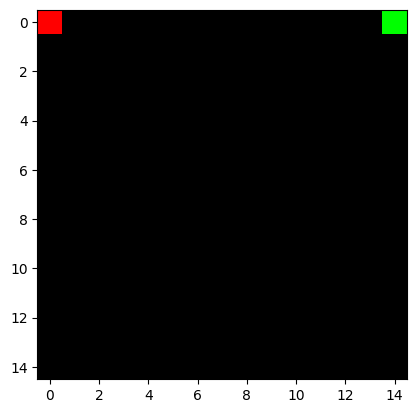

In [36]:
grid_size = 15
pattern="empty"
env = SimpleGrid(grid_size, block_pattern=pattern, obs_mode="index")
env.reset(agent_pos=[0,0], goal_pos=[0, grid_size-1])
plt.imshow(env.grid)

## Setting up the agent

This is the agent class. The main variables in the class are `w`, which is the reward estimate vector, and `M`, which is the successor matrix. Since we are going to be using it to generate Q values rather than V values, it is a three-dimensional tensor, with the first dimension corresponding to the action.

In [37]:
class TabularSuccessorAgent(object):
    def __init__(self, state_size, action_size, learning_rate, gamma):
        self.state_size = state_size
        self.action_size = action_size
        self.M = np.stack([np.identity(state_size) for i in range(action_size)])
        self.w = np.zeros([state_size])
        self.learning_rate = learning_rate
        self.gamma = gamma
        
    def Q_estimates(self, state, goal=None):
        # Generate Q values for all actions.
        if goal == None:
            goal = self.w
        else:
            goal = utils.onehot(goal, self.state_size)
        return np.matmul(self.M[:,state,:],goal)
    
    def sample_action(self, state, goal=None, epsilon=0.0):
        # Samples action using epsilon-greedy approach
        if np.random.uniform(0, 1) < epsilon:
            action = np.random.randint(self.action_size)
        else:
            Qs = self.Q_estimates(state, goal)
            action = np.argmax(Qs)
        return action
    
    def update_w(self, current_exp):
        # A simple update rule
        s_1 = current_exp[2]
        r = current_exp[3]
        error = r - self.w[s_1]
        self.w[s_1] += self.learning_rate * error        
        return error
    
    def update_sr(self, current_exp, next_exp):
        # SARSA TD learning rule
        s = current_exp[0]
        s_a = current_exp[1]
        s_1 = current_exp[2]
        s_a_1 = next_exp[1]
        r = current_exp[3]
        d = current_exp[4]
        I = utils.onehot(s, env.state_size)
        if d:            
            td_error = (I + self.gamma * utils.onehot(s_1, env.state_size) - self.M[s_a, s, :])
        else:
            td_error = (I + self.gamma * self.M[s_a_1, s_1, :] - self.M[s_a, s, :])
        self.M[s_a, s, :] += self.learning_rate * td_error
        return td_error

## Learning online from experience

The learning procedure is online, with the agent updating using pairs of `<state, action, reward, next_state, next_action>`, i.e. SARSA. The agent takes actions using an epsilon-greedy policy.

Halfway through learning the goal location is changed, and the agent has to re-learn it's `w` vector.

Episode 2450/5000, TD Error: 0.027796477517960393, Test Lengths: 14.84
Switched reward locations
Episode 4950/5000, TD Error: 0.027521569948388037, Test Lengths: 13.26

Text(0.5, 1.0, 'Episode Lengths')

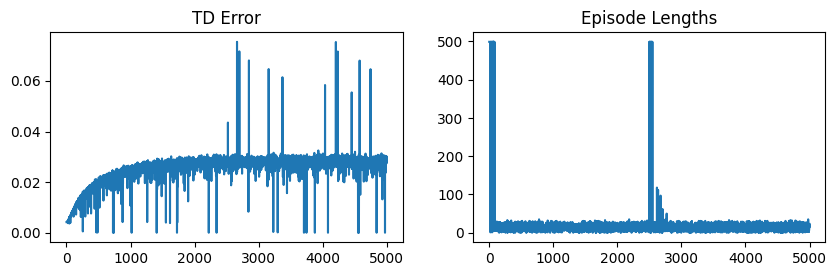

In [38]:
# Helper Function for respawn point generation
def random_valid_position(env):
    # Create a list of all valid positions
    valid_positions = [
        [x, y] for x in range(env.grid_size) for y in range(env.grid_size)
        if [x, y] not in env.blocks
    ]
    
    # Randomly select a position from the list of valid positions
    return valid_positions[np.random.randint(len(valid_positions))]

train_episode_length = 500
test_episode_length = 500
episodes = 5000
gamma = 0.95
lr = 5e-2
train_epsilon = 1.0
test_epsilon = 0.1

agent = TabularSuccessorAgent(env.state_size, env.action_size, lr, gamma)

experiences = []
test_experiences = []
test_lengths = []
lifetime_td_errors = []

for i in range(episodes):
    # Train phase
    # agent_start = [0,0]
    agent_start = random_valid_position(env)
    if i < episodes // 2:
        goal_pos = [0, grid_size-1]
    else:
        if i == episodes // 2:
            print("\nSwitched reward locations")
        goal_pos = [grid_size-1,grid_size-1]
    env.reset(agent_pos=agent_start, goal_pos=goal_pos)
    state = env.observation
    episodic_error = []
    for j in range(train_episode_length):
        action = agent.sample_action(state, epsilon=train_epsilon)
        reward = env.step(action)
        state_next = env.observation
        done = env.done
        experiences.append([state, action, state_next, reward, done])
        state = state_next
        if (j > 1):
            td_sr = agent.update_sr(experiences[-2], experiences[-1])
            td_w = agent.update_w(experiences[-1])
            episodic_error.append(np.mean(np.abs(td_sr)))
        if env.done:
            td_sr = agent.update_sr(experiences[-1], experiences[-1])
            episodic_error.append(np.mean(np.abs(td_sr)))
            break
    lifetime_td_errors.append(np.mean(episodic_error))
    
    # Test phase
    env.reset(agent_pos=agent_start, goal_pos=goal_pos)
    state = env.observation
    for j in range(test_episode_length):
        action = agent.sample_action(state, epsilon=test_epsilon)
        reward = env.step(action)
        state_next = env.observation
        test_experiences.append([state, action, state_next, reward])
        state = state_next
        if env.done:
            break
    test_lengths.append(j)
    
    if i % 50 == 0:
        print('\rEpisode {}/{}, TD Error: {}, Test Lengths: {}'
              .format(i, episodes, np.mean(lifetime_td_errors[-50:]), 
                      np.mean(test_lengths[-50:])), end='')

fig = plt.figure(figsize=(10, 6))

ax = fig.add_subplot(2, 2, 1)
ax.plot(lifetime_td_errors)
ax.set_title("TD Error")
ax = fig.add_subplot(2, 2, 2)
ax.plot(test_lengths)
ax.set_title("Episode Lengths")

## Agent Representation Analysis

Once the agent has solved the navigation task and learned `M` and `w`, we can examine these learned representations.

In [39]:
def print_occupancy(experiences, grid_size):
    occupancy_grid = np.zeros([grid_size, grid_size])
    for experience in experiences:
        occupancy_grid += env.state_to_grid(experience[0])
    occupancy_grid = np.sqrt(occupancy_grid)
    occupancy_grid = utils.mask_grid(occupancy_grid, env.blocks)
    plt.imshow(occupancy_grid)

### Visualize state occupancy

First, we can take a look at what states the agent most frequently visited during training and testing.

#### During training

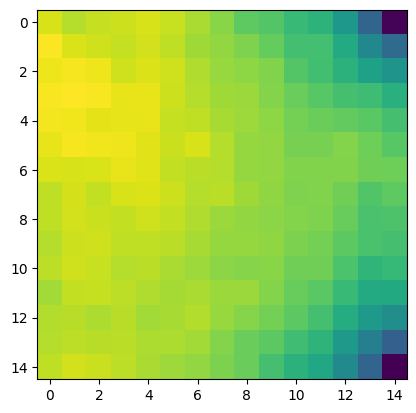

In [40]:
print_occupancy(experiences, grid_size)

#### During evaluation

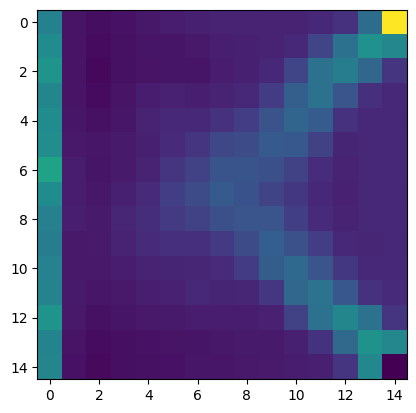

In [41]:
print_occupancy(test_experiences, grid_size)

### Raw successor matrix

We can visualize the raw successor matrix. It may not be very interpretable though. Fortunately there are other more useful methods.

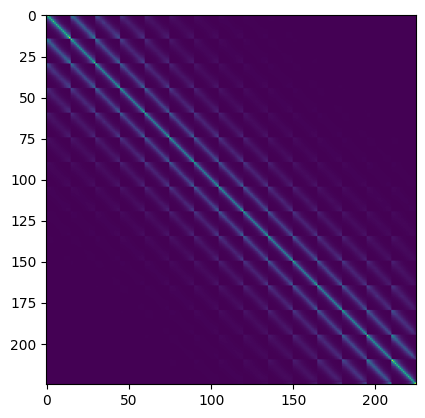

In [42]:
averaged_M = np.mean(agent.M, axis=0)
plt.imshow(averaged_M)

### Analyze Eigen Value Decomposition for the SR
 

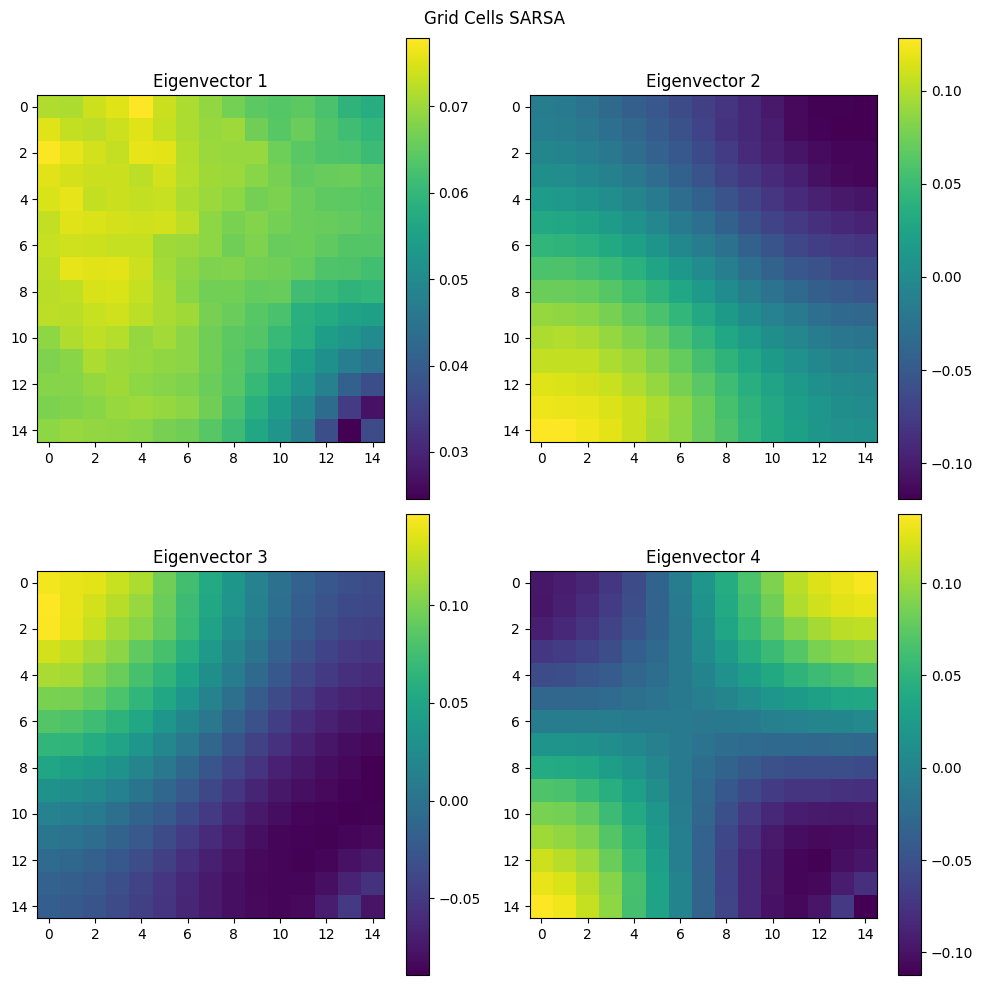

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt
# Assuming you have 'agent' and 'env' objects available

def plot_grid_cells(agent, env, title):
    # Reshape the SR matrix to be state_size x state_size for eigen decomposition
    sr_matrix = np.mean(agent.M, axis=0)  # Averaging over actions
    
    # Perform eigen decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(sr_matrix)
    
    # Sort the eigenvectors by the corresponding eigenvalues in descending order
    idx = np.argsort(-eigenvalues)
    eigenvectors = eigenvectors[:, idx]
    
    # Plot the first few principal eigenvectors (grid cells)
    num_grid_cells = 4  # Adjust the number of grid cells to plot
    plt.figure(figsize=(10, 10))
    
    for i in range(num_grid_cells):
        plt.subplot(2, 2, i + 1)
        grid_cell = np.reshape(eigenvectors[:, i], (env.grid_size, env.grid_size))
        plt.imshow(grid_cell, cmap='viridis')
        plt.title(f'Eigenvector {i + 1}')
        plt.colorbar()
    
    plt.suptitle(title)
    plt.tight_layout()
    
    # Display the plot in the notebook
    plt.show()

# After epsilon-greedy policy training
plot_grid_cells(agent, env, "Grid Cells SARSA")


### Analyze SR for each state

Instead of looking at the full `M` matrix, we can plot the successor representation for each state onto the environment itself.

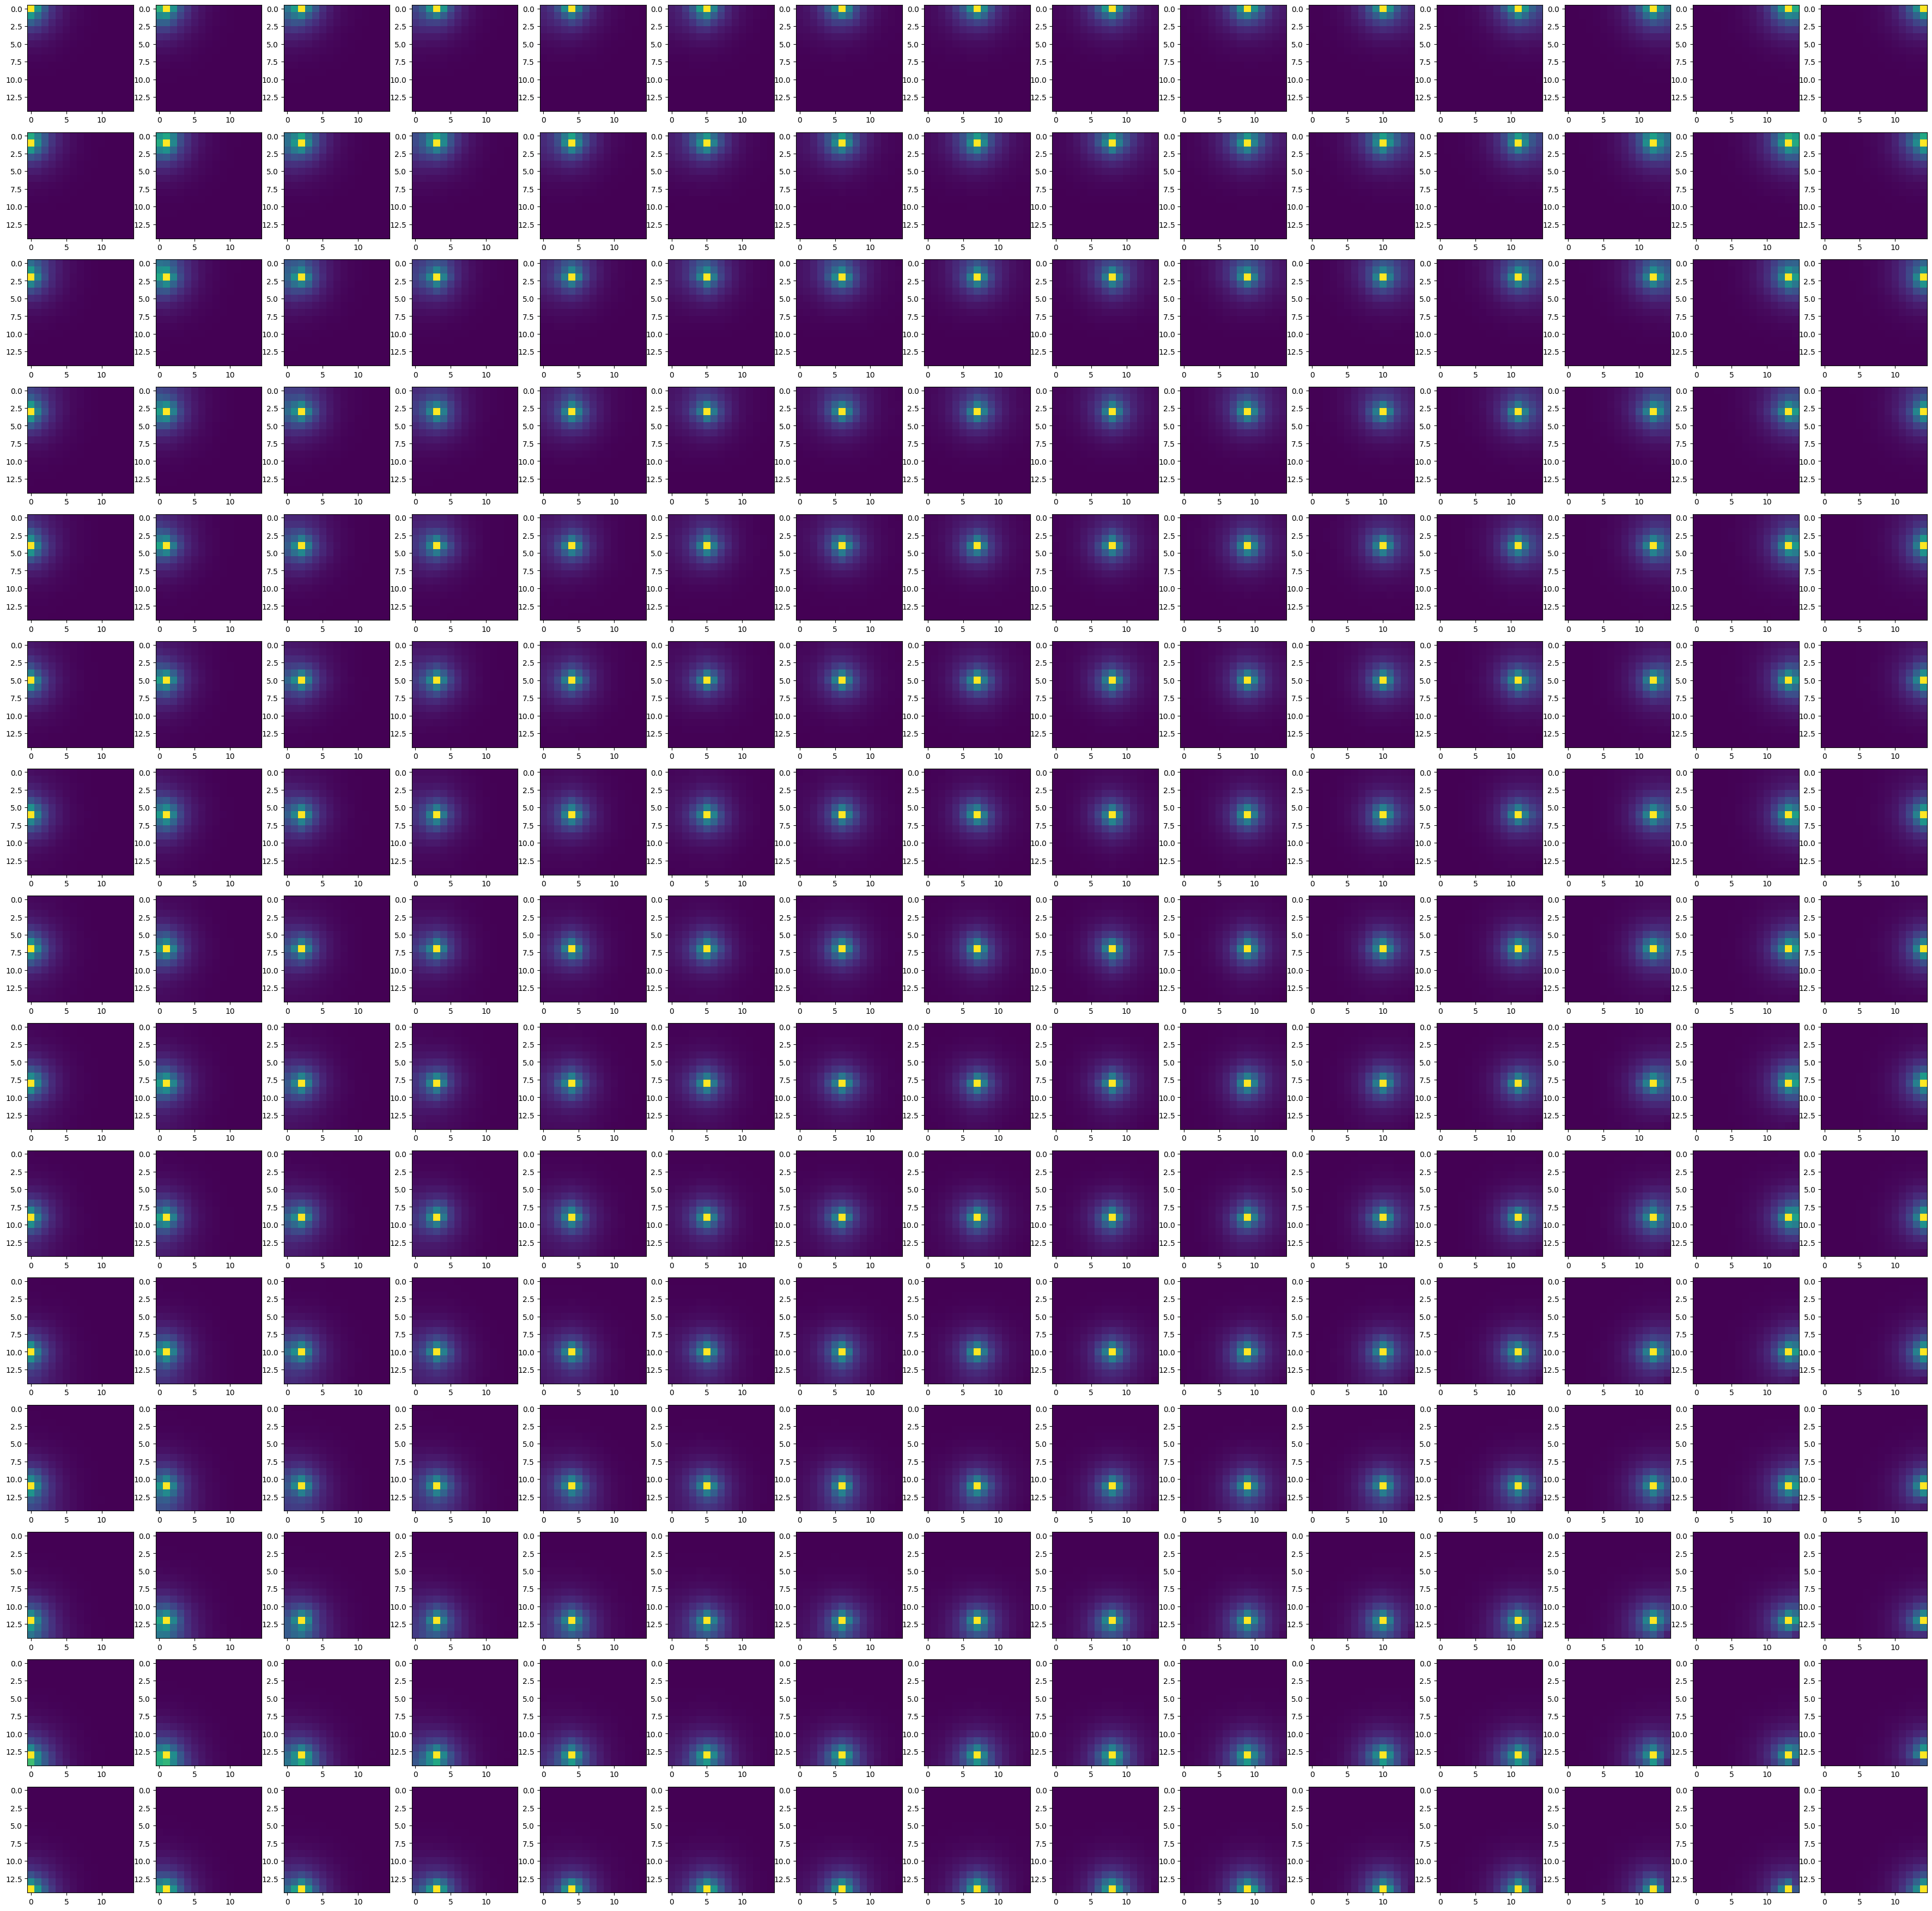

In [44]:
averaged_M = np.reshape(averaged_M, [env.state_size, grid_size, grid_size])

cmap = plt.cm.viridis
cmap.set_bad(color='white')

plt.figure(1, figsize=(grid_size*3, grid_size*3))
for i in range(env.state_size):
    if env.state_to_point(i) not in env.blocks:
        ax = plt.subplot(grid_size, grid_size, i + 1)
        ax.imshow(utils.mask_grid(averaged_M[i,:,:], env.blocks), cmap=cmap)

### Visualize bottleneck states

It is also possible to analyze the learned successor representation for all of the states via dimensionality reduction. This can tell us how the different states relate to one another. In the case of the `four_rooms` environment, we find that states within each room are all most similar to other states in that room. We also find that the four door states between rooms are represented uniquely. Because of this, they are potential candidates for bottleneck states that might be used in a hierarchical agent.

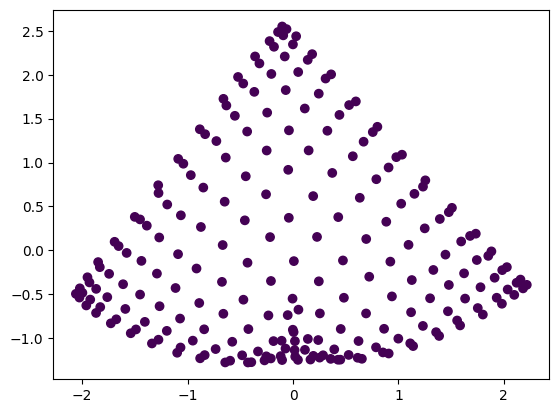

In [45]:
M_s = np.mean(agent.M[:,:,:], axis=0)
colors = np.zeros([env.state_size])
for bottleneck in env.bottlenecks:
    grid = np.zeros([env.grid_size,env.grid_size])
    grid[bottleneck[0],bottleneck[1]] = 1
    grid = grid.flatten()
    b_state = np.where(grid==1)[0][0]
    colors[b_state] = 1
pca = PCA(n_components=2)
pca_result = pca.fit_transform(M_s[:])

plt.scatter(pca_result[:,0], pca_result[:,1], c=colors)

### Value estimates

We can also examine `w` by using it to generate Q values, and plotting them onto the environment itself. We find that a gradient of value flows from the rewarding state.

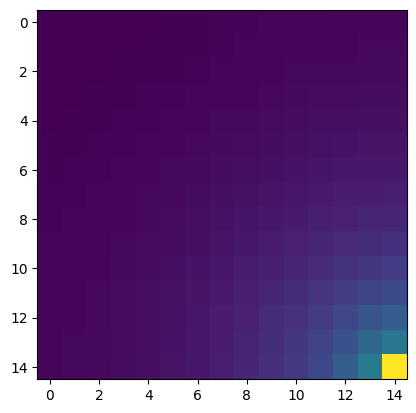

In [46]:
a = np.zeros([env.state_size])
for i in range(env.state_size):
    Qs = agent.Q_estimates(i)
    V = np.mean(Qs)
    a[i] = V
V_Map = np.reshape(a, [grid_size, grid_size])
V_Map = np.sqrt(V_Map)

V_Map = utils.mask_grid(V_Map, env.blocks)

plt.imshow(V_Map)

### Optional - Analyze SR for each state-action pair

Lastly, we can examine the successor representation for each state/action pair. This shows us the way in which the successor map for each action is slightly biased in the direction of that action.

In [47]:
def plot_srs(action, M):
    M = np.reshape(M, [env.action_size, env.state_size, grid_size, grid_size])
    M = np.sqrt(M)
    plt.figure(1, figsize=(grid_size*3, grid_size*3))
    for i in range(grid_size*grid_size):
        if env.state_to_point(i) not in env.blocks:
            ax = plt.subplot(grid_size, grid_size, i + 1)
            ax.imshow(utils.mask_grid(M[action,i,:,:], env.blocks))

#### Up action

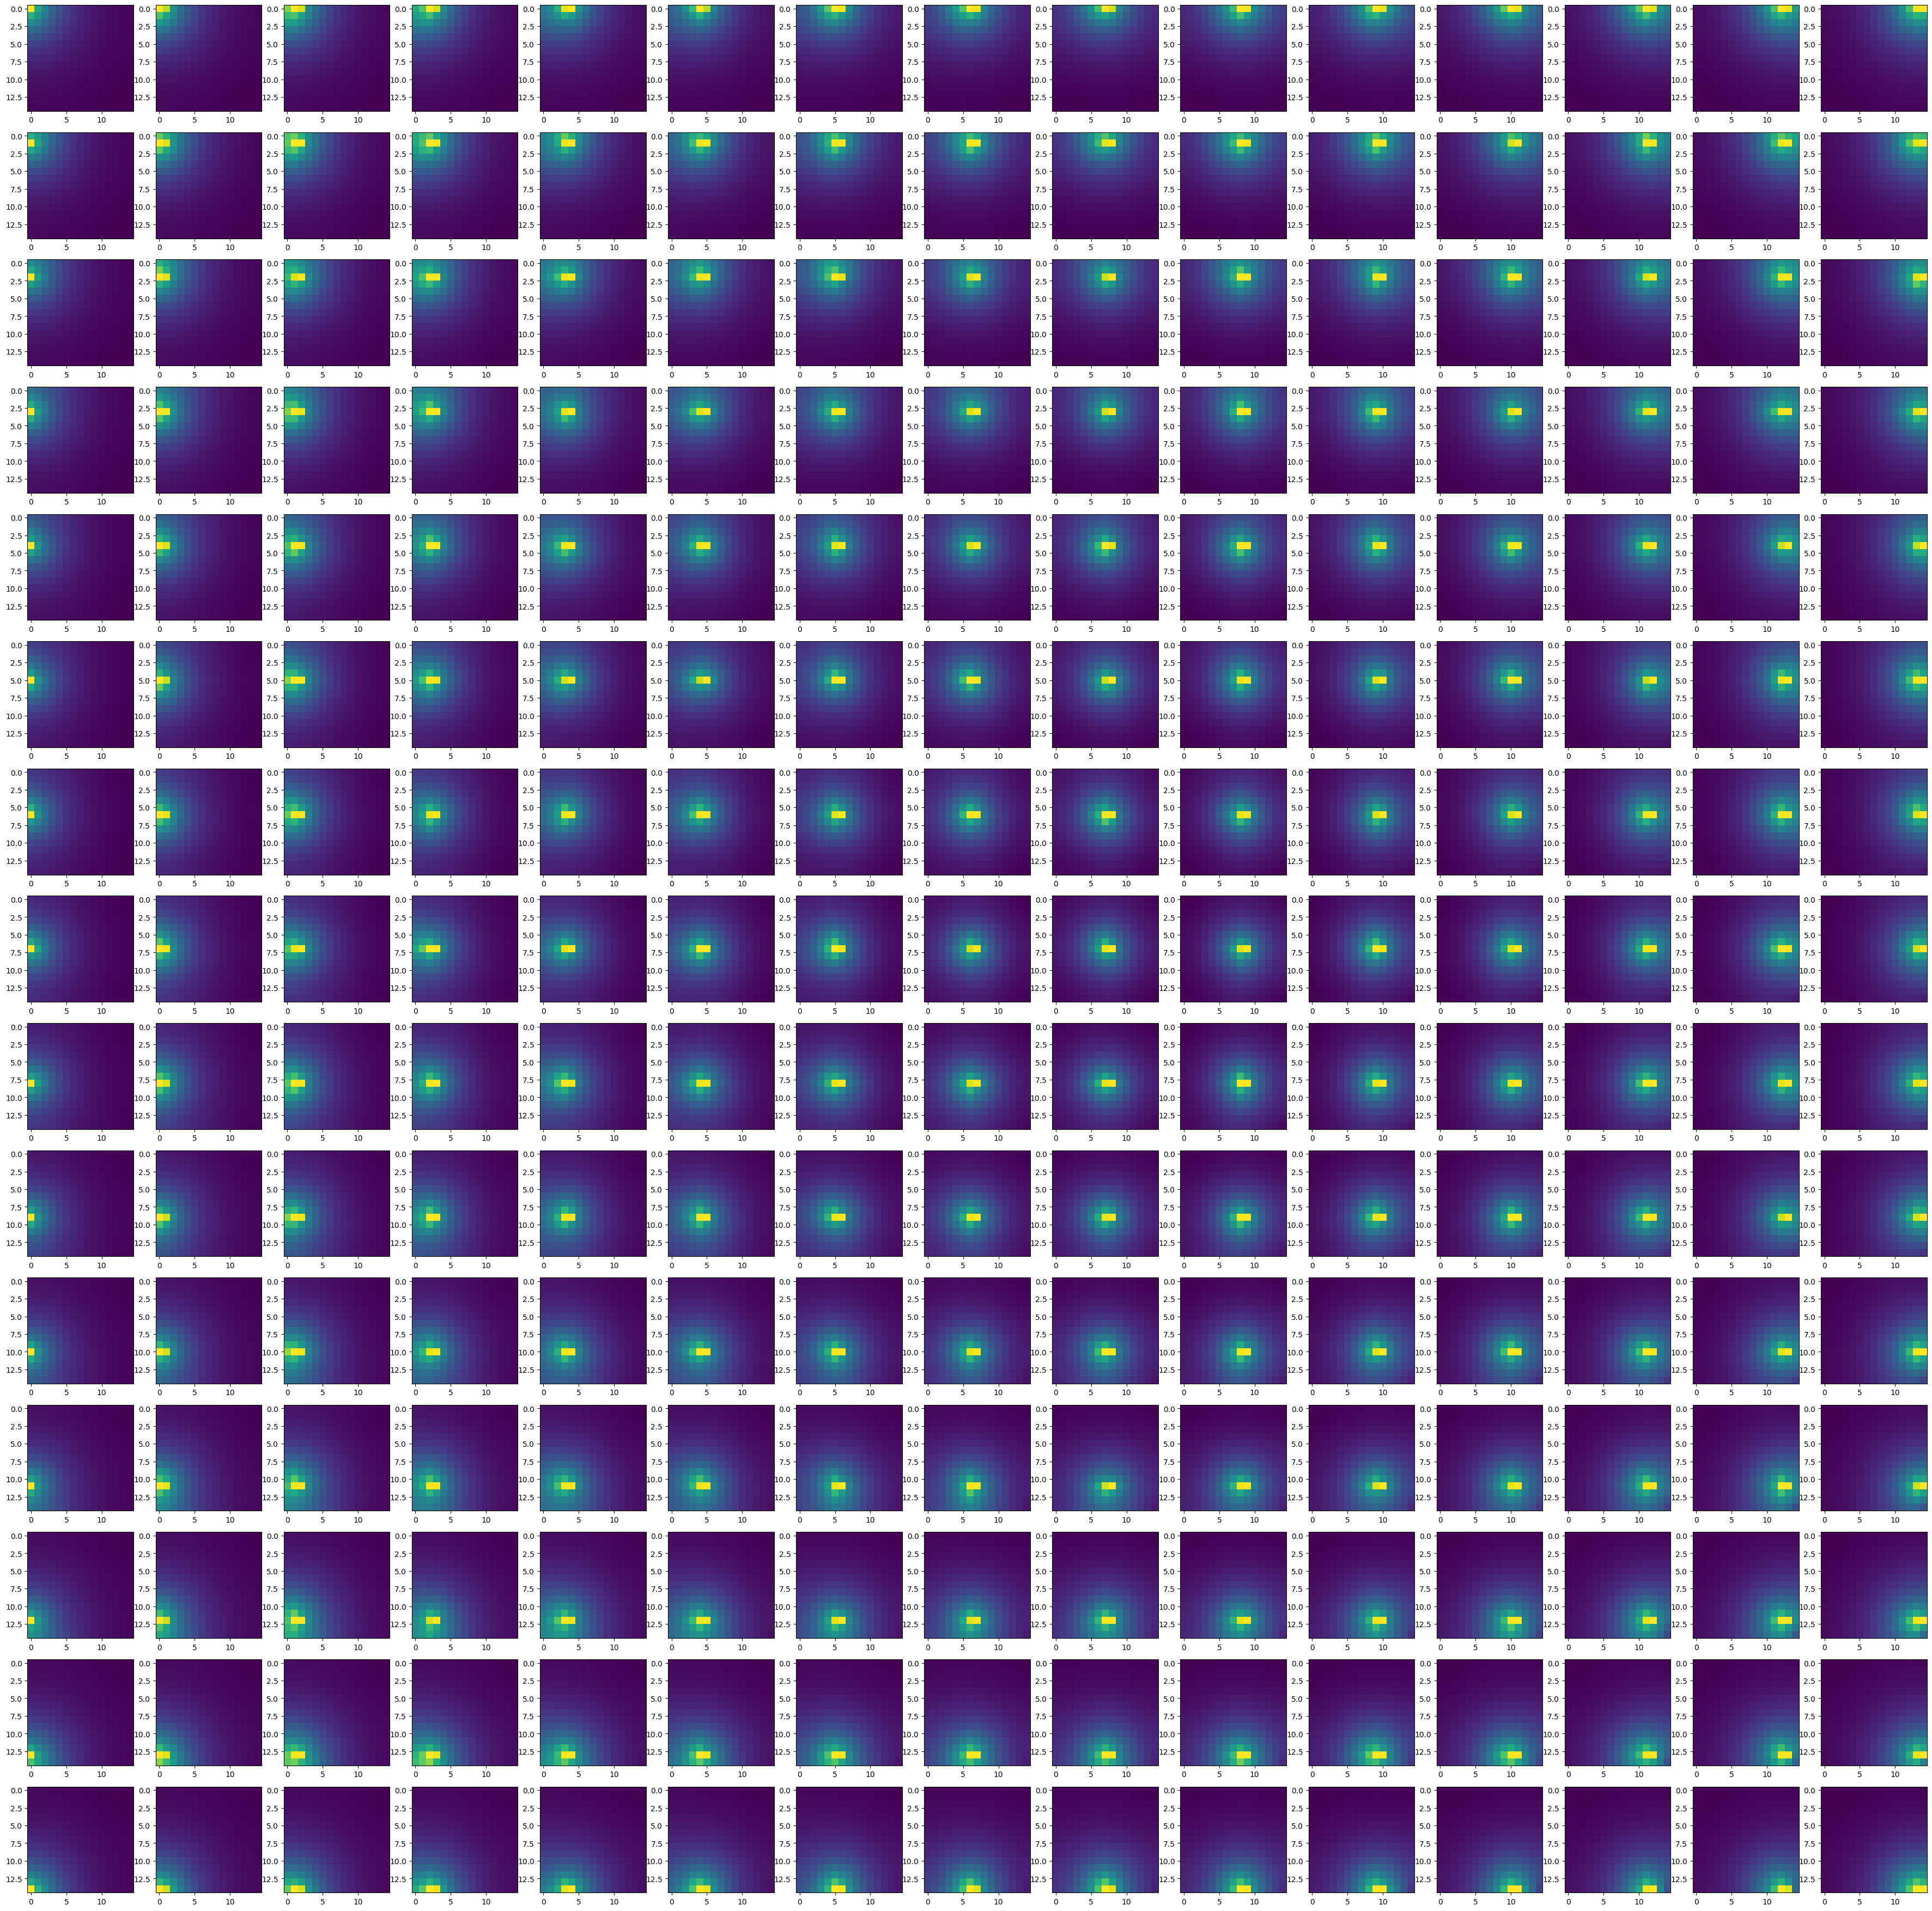

In [48]:
plot_srs(0, agent.M)

#### Down action

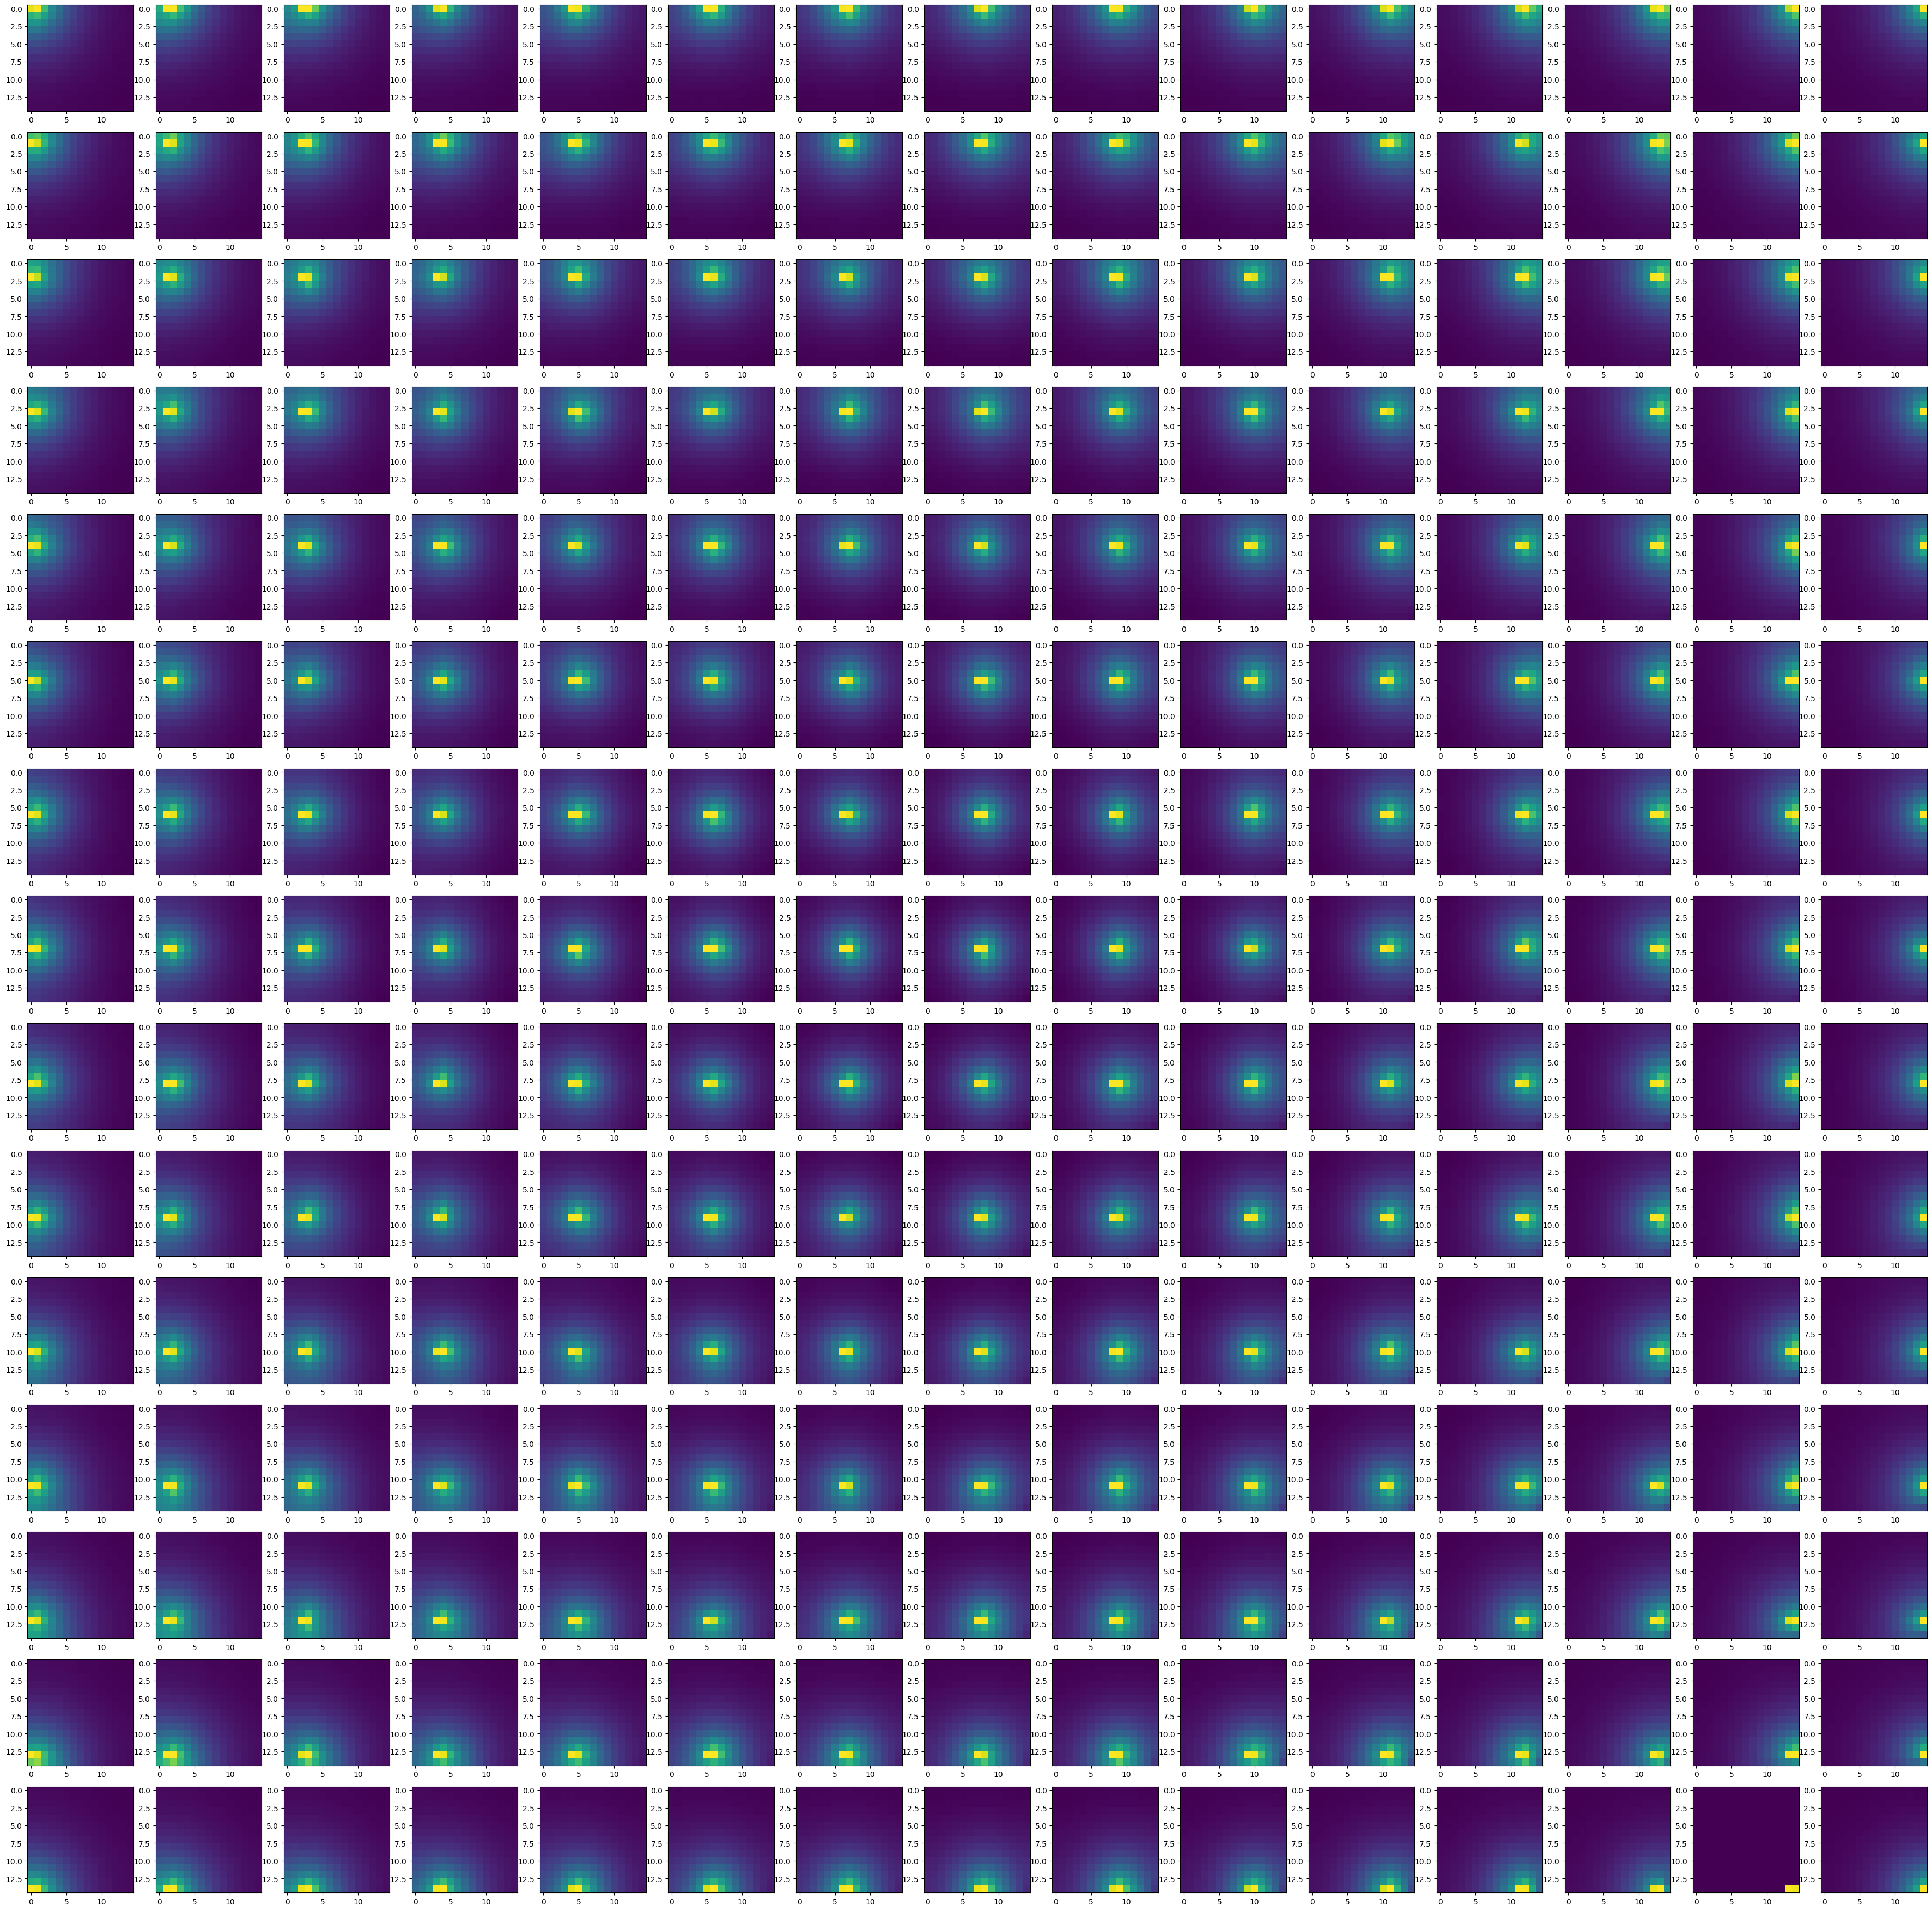

In [49]:
plot_srs(1, agent.M)

#### Left action

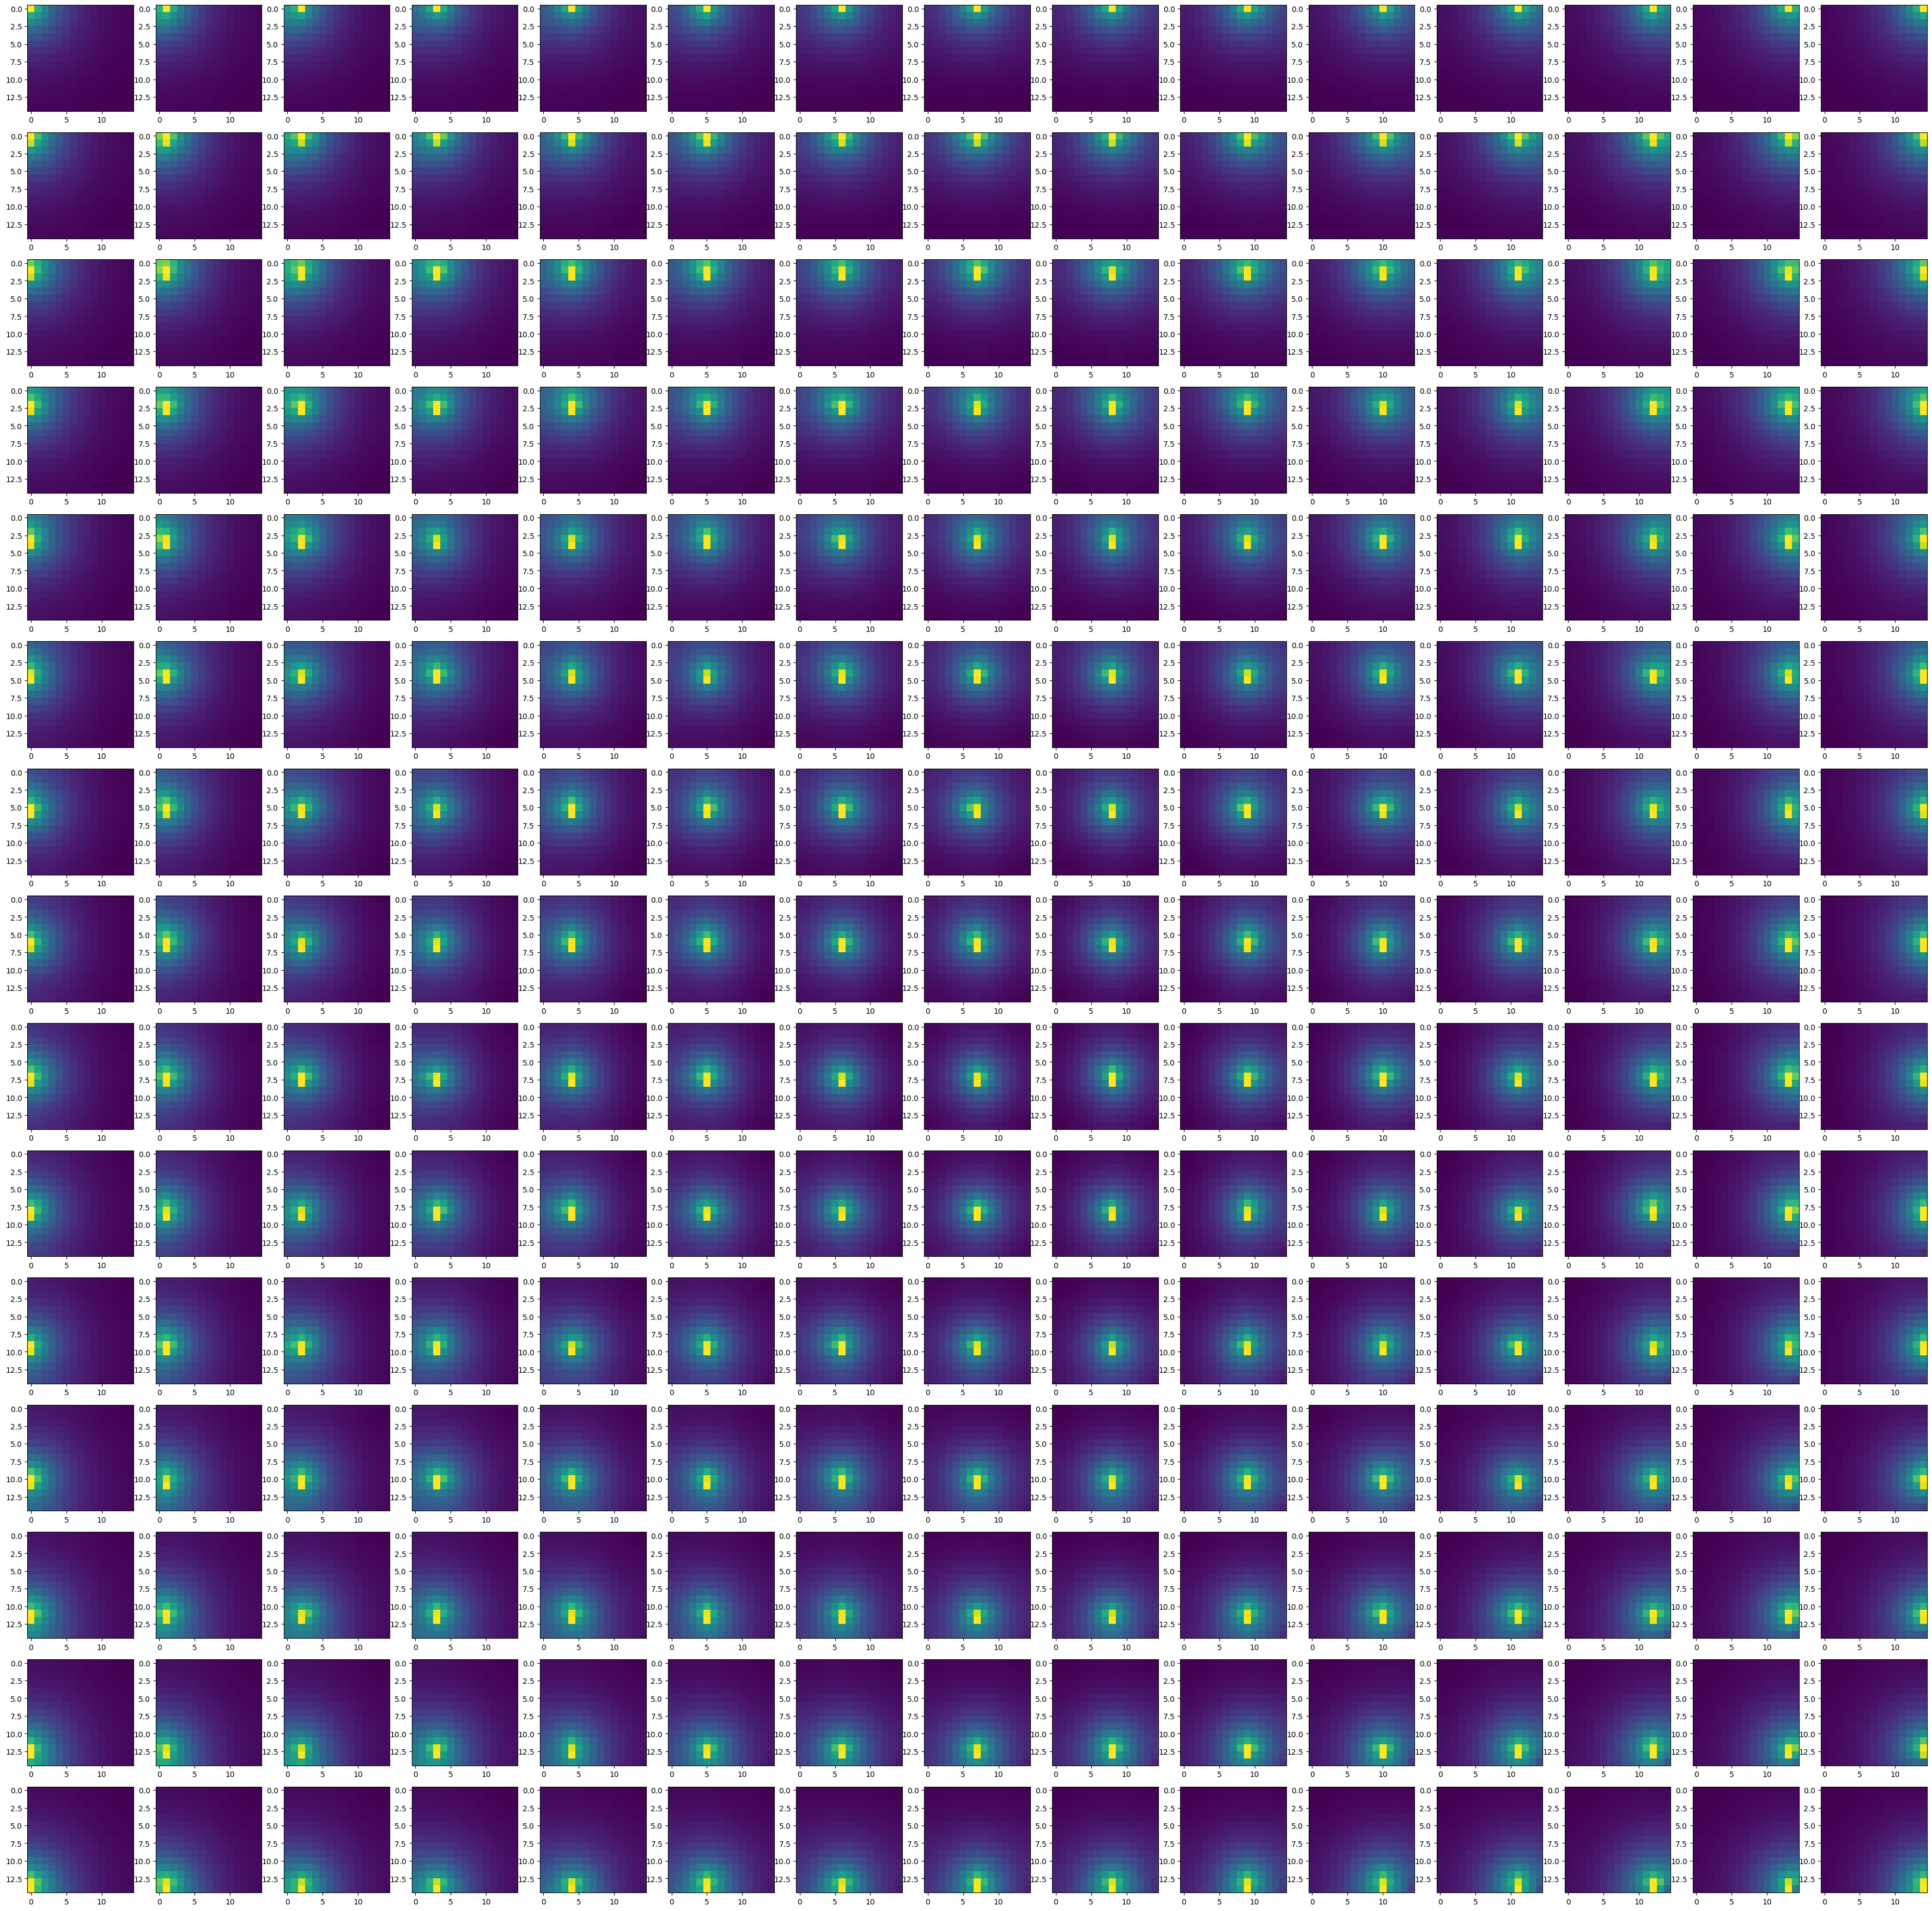

In [50]:
plot_srs(2, agent.M)

#### Right action

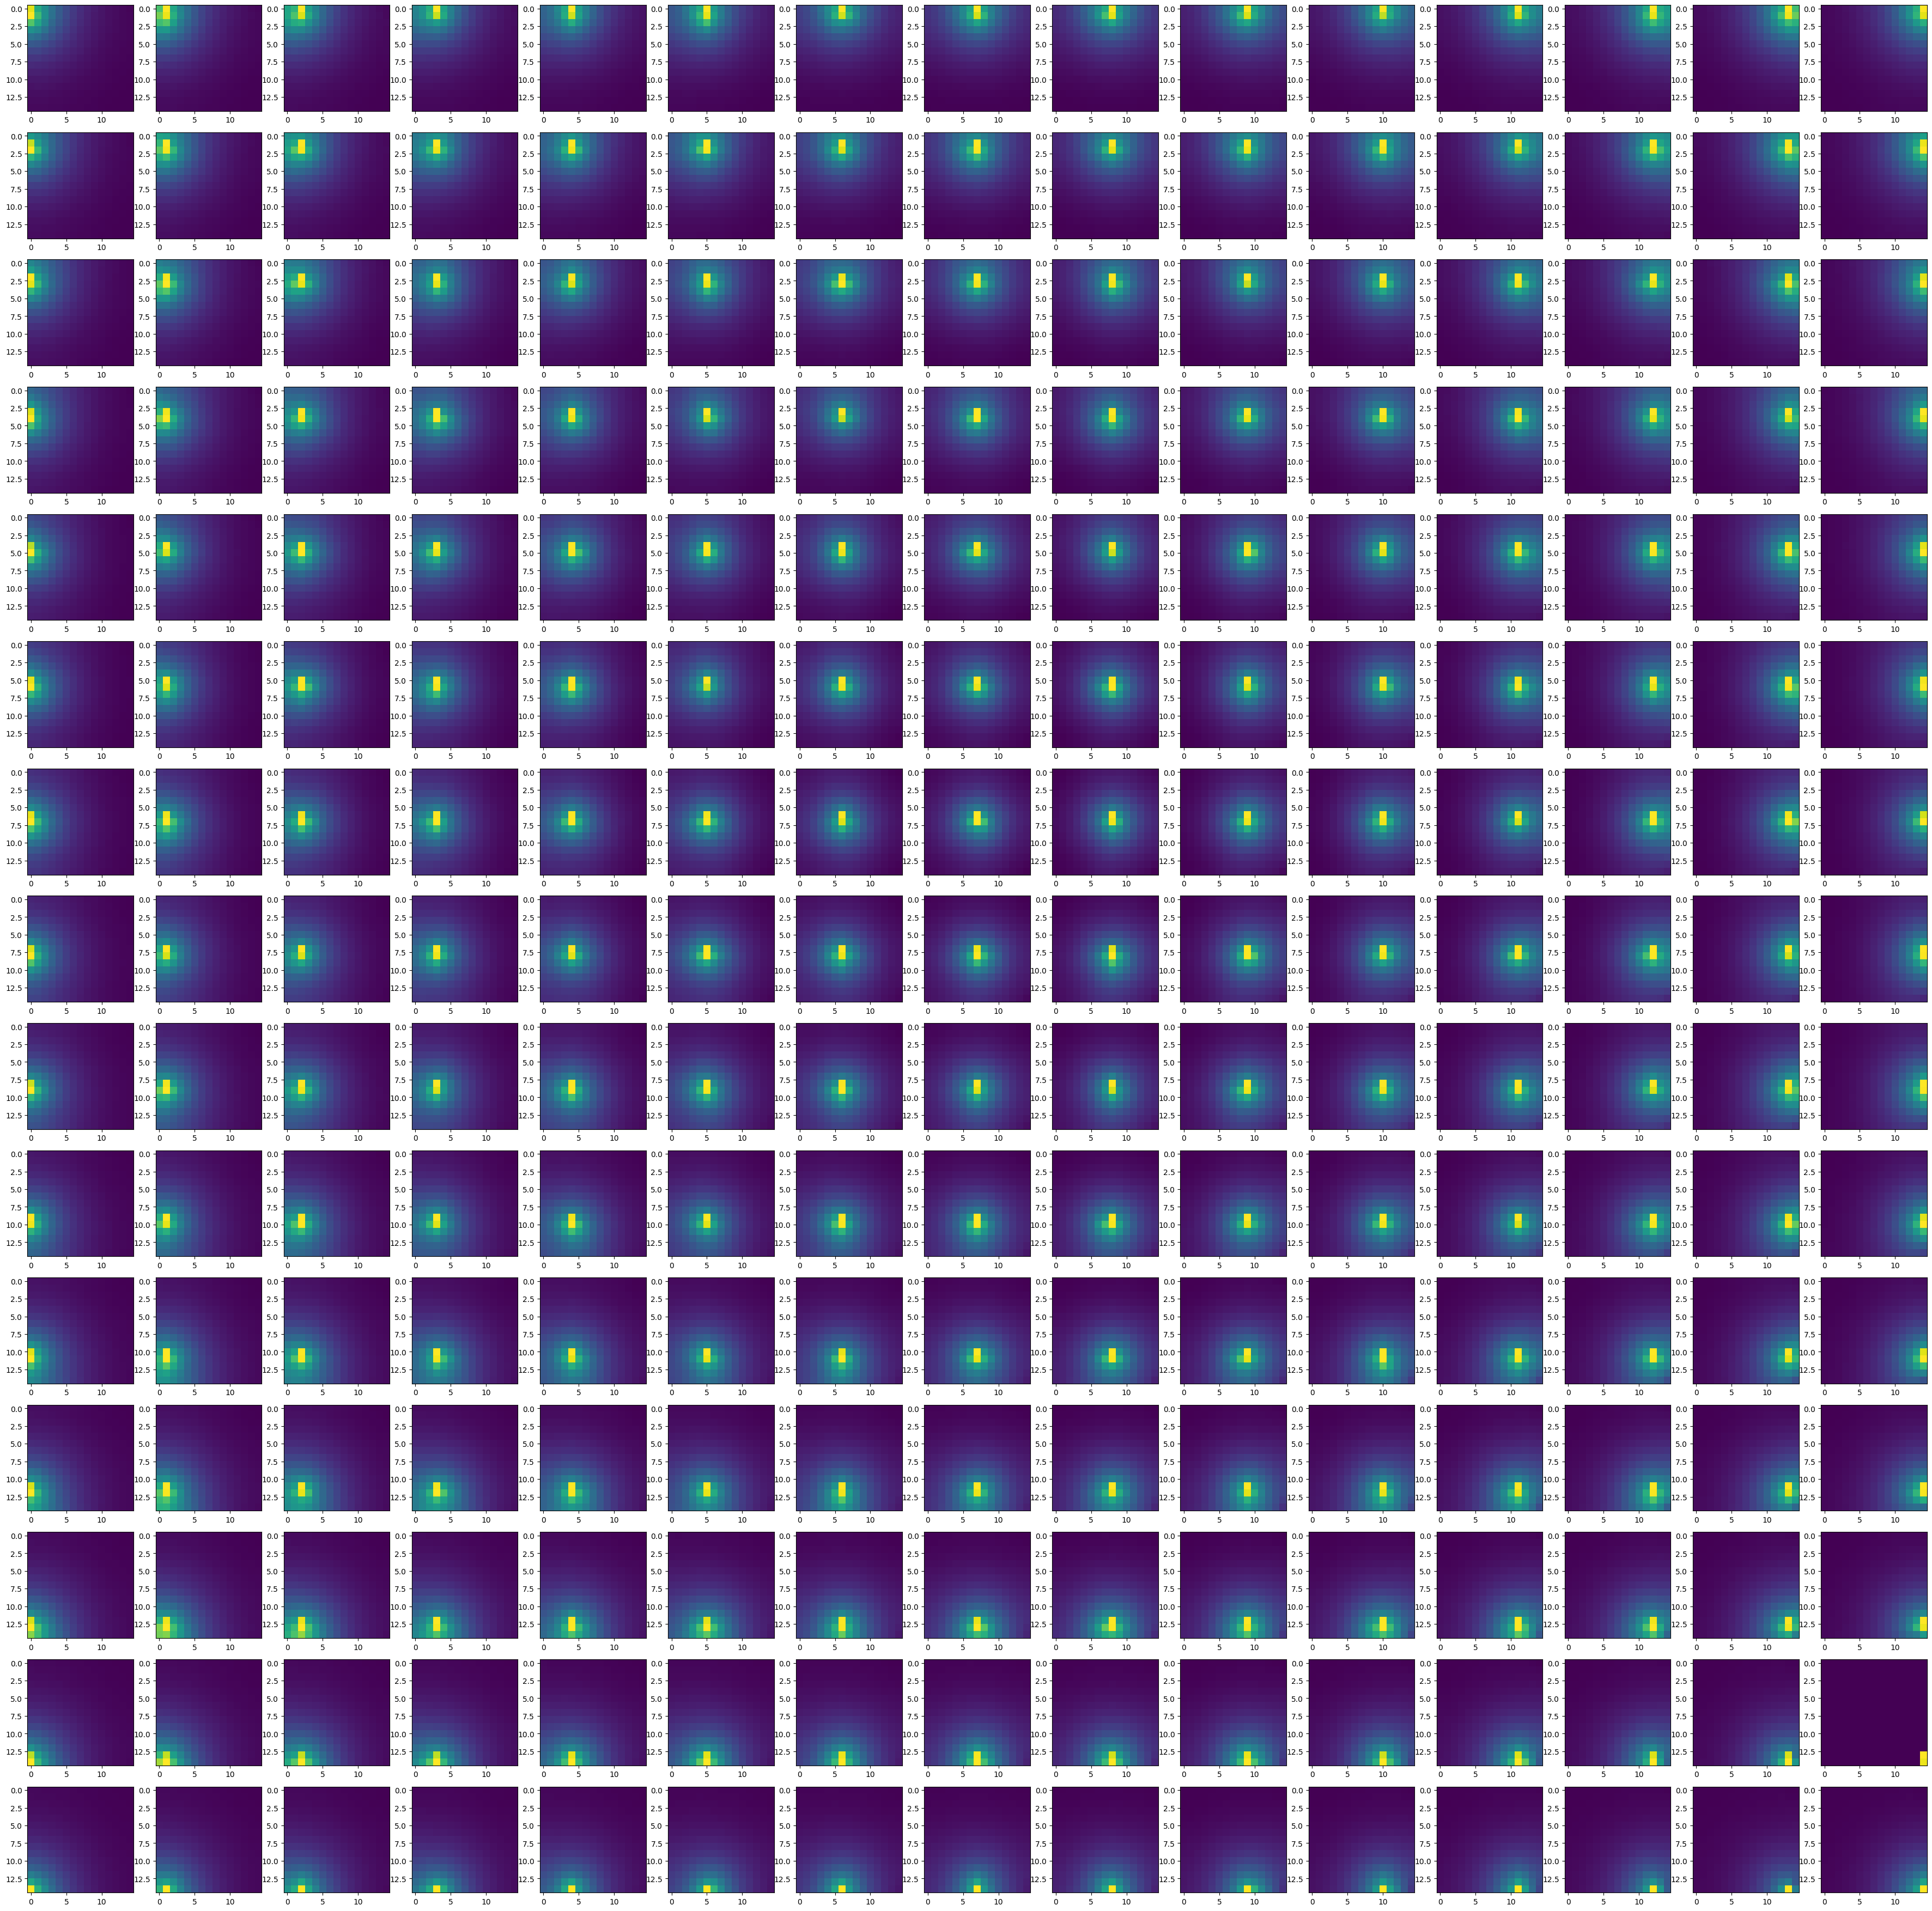

In [51]:
plot_srs(3, agent.M)